In [2]:
%matplotlib inline
import numpy as np
import pylab as pl

## Ejemplo cuencas

En el siguiente ejemplo se presentan las funcionalidades básicas de la herramienta **wmf.Stream** y **wmf.Basin**
dentro de los temas tocados se presenta:

- Trazado de corrientes.
- Perfil de corrientes.
- Trazado de cuencas.
- Balances para estimación de caudal.
- Análisis Geomorfológico de cuencas.


In [47]:
#Paquete Watershed Modelling Framework (WMF) para el trabajo con cuencas.
from wmf import wmf

Este es como se leen los mapas de direcciones y dem para el trazado de cuencas y corrientes 

In [49]:
# Lectura del DEM
DEM = wmf.read_map_raster('/media/nicolas/discoGrande/raster/dem_corr.tif',isDEMorDIR=True, dxp=30.0)

In [54]:
DIR = wmf.read_map_raster('/media/nicolas/discoGrande/raster/dirAMVA.tif',isDEMorDIR=True, dxp= 30.0)

In [60]:
wmf.cu.nodata=-9999.0; wmf.cu.dxp=30.0
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass(DIR,wmf.cu.ncols,wmf.cu.nrows)

### Trazado de corrientes

Importantes para determinar por donde se acumula el flujo y por lo tanto por donde se debe trazar la cuenca, estos elementos operan más como una guia que como un resultado final, pueden ser usados directamente para el trazado de las cuencas acudiendo a su propiedad **structure**, en la cual en las dos primeras entradas se alojan la coordenada **X** y la coordenada **Y**

Trazado de una corriente 

In [63]:
st = wmf.Stream(-75.618,6.00,DEM=DEM,DIR=DIR,name ='Rio Medellin')

In [107]:
st.structure

array([[ -7.56180191e+01,  -7.56177444e+01,  -7.56174622e+01, ...,
         -7.51850433e+01,  -7.51847687e+01,  -7.51844864e+01],
       [  6.00003529e+00,   6.00031424e+00,   6.00059271e+00, ...,
          6.55289555e+00,   6.55289555e+00,   6.55289555e+00],
       [  2.32600000e+03,   2.31400000e+03,   2.30200000e+03, ...,
          1.06000000e+03,   1.06000000e+03,   1.06100000e+03],
       [  4.20000000e+01,   8.40000000e+01,   1.26000000e+02, ...,
          1.05678000e+05,   1.05708000e+05,   1.05738000e+05]], dtype=float32)

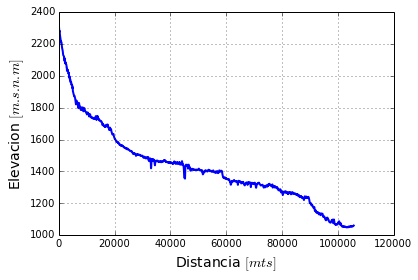

In [67]:
st.Plot_Profile()

El perfil de una corriente puede ser utilizado como punto de referencia para la búsqueda de puntos de trazado 

In [83]:
# Mediante el comando de busqueda hemos buscado donde se localizan las coordenadas que cumplen la propiedad de estar a 
#una distancia de la salida que oscila entre 10000 y 10100 metros.
np.where((st.structure[3]>10000) & (st.structure[3]<10100))

(array([289, 290, 291, 292]),)

## Trazado de cuenca 

Trazado de cuencas mediante el objeto **Basin**

La cuenca se traza a partir de un par de coordenadas, de un DEM y de un DIR, se le pueden agregar parametros como el nombre o el umbral para producir corrientes, pero este es opcional, este tipo de cuencas no se dejan simular, para ello se debe usar la herramienta **SimuBasin** 

In [84]:
# Las coordenadas en la entrada 289 son:
print st.structure[0,289]
print st.structure[1,289]

-75.6322
6.07364


In [127]:
# La cuenca puede ser trtazada utilizando las coordenadas de forma implicita (como en este ejemplo), o de una 
# manera explicita como se realizaría en la segunda línea de código.
cuenca = wmf.Basin(-75.6364,6.11051,DEM,DIR,name='ejemplo',stream=st)
# en esta segunda linea estamos trazando una cuenca con unas coordenadas que no son exactas y no se sabe si estan 
# sobre la corriente, este problema se corrige al pasarle la corriente al trazador mediante el comando stream, el cual 
# recibe como entrada el objeto corriente previamente obtenido.
cuenca2 = wmf.Basin(-75.6422,6.082,DEM,DIR,name='ejemplo',stream=st)
# Cuenca error: en este caso no se para el argumento stream, por lo que la cuenca se traza sobre las coordenadas 
# que se han dado, lo cual probablemente produzca un error.
cuenca3 = wmf.Basin(-75.6364,6.11051,DEM,DIR,name='ejemplo',stream=st)

In [128]:
# Se imprime la cantidad de celdas que comprenden a cada una de las cuencas obtenidas, esto para ver que efectivamente 
# existe una diferencia entre ambas debida a las diferencias de coordenadas.
print cuenca.ncells
print cuenca2.ncells
print cuenca3.ncells

107024
60893
107024


La ultima cuenca tiene un conteo de celdas igual a 1, lo cual significa que no se ha trazado nada y que por esta celda no pasa ninguna otra celda, por lo tanto esto no es una cuenca, y no debe ser usado para ningún tipo de cálculos, en la siguiente línea este elemento es eliminado:

In [129]:
del(cuenca3)

### Balance sobre cuencas

EL objeto **Basin** Trae por defecto funciones para el cálculño de propiedades geomorfológicas y para el cálculo de caudales mediante el método de balances de largo plazo. a continuación se presenta la funcionalidad del mismo.

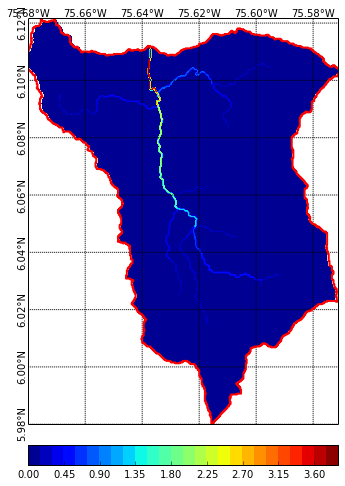

In [130]:
# Balance en una cuenca asumiendo precipitación anual igual a 2000 mm/año sobre toda la cuenca 
cuenca.GetQ_Balance(2100)
# La variable de balance de largo plazo se calcula para cada celda de la cuenca y queda almacenada en cuenca.CellQmed
cuenca.Plot_basin(cuenca.CellQmed)

En la Figura se presenta el caudal medio estimado para cada elemento de la cuenca, incluidas celdas en donde no se considera la presencia de red hídrica.

Cuando se ha calculado el caudal medi tambien se ha calculado la evaporación sobre la cuenca, esta se puede ver en la variable **cuenca.CellETR**

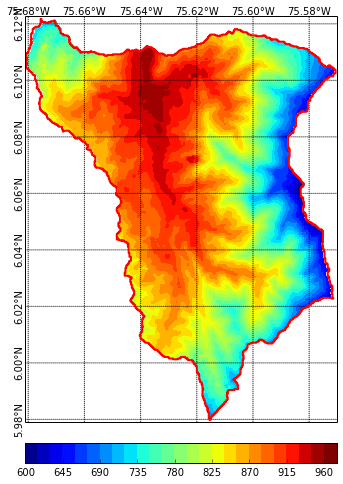

In [131]:
# Plot de la evaporación sobre la cuenca de caldas
cuenca.Plot_basin(cuenca.CellETR, extra_lat= 0.001, extra_long= 0.001, lines_spaces= 0.02,
    ruta = 'Caldas_ETR.png')

La figura anterior ha sido guardada en el disco mediante el comando **ruta = 'Caldas_ETR.png'**, en este caso ha sido sobre el directorio de trabajo actual, si este se cambia, se cambia el directorio donde se guarda.

El módulo permite estimar caudales máximos y mínimos mediante rtegionalización de caudales extremos mediante la ecuación:

- $Q_{max}(T_r) = \widehat{Q}_{max} + K_{dist}(T_r) \sigma_{max}$ 
- $Q_{min}(T_r) = \widehat{Q}_{min} - K_{dist}(T_r) \sigma_{min}$ 


In [132]:
# Estimacion de maximos, por defecto lo hace por gumbel, lo puede hacer tambien por lognormal
Qmax = cuenca.GetQ_Max(cuenca.CellQmed)
Qmax2 = cuenca.GetQ_Max(cuenca.CellQmed, Tr= [3, 15])
# Estimacion de minimos, por defecto lo hace por gumbel, lo puede hacer tambien por lognormal
Qmin = cuenca.GetQ_Min(cuenca.CellQmed)
Qmin[Qmin<0]=0

Cada entrada en **Qmax** y **Qmin** corresponde al periodo de retorno Tr [2.33, 5, 10, 25, 50, 100], estos pueden ser cambiados al interior de la función al cambiar la propiedad **Tr** en el momento en que esta es invocada.

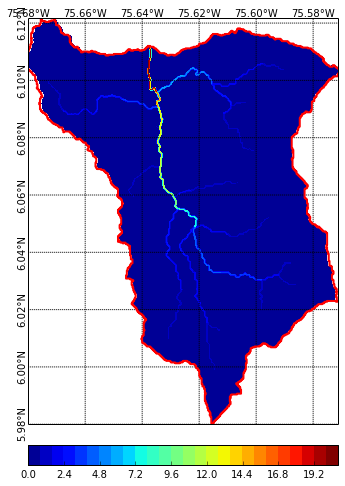

In [133]:
# Plot del caudal máximo para un periodo de retorno de 2.33
cuenca.Plot_basin(Qmax[0])

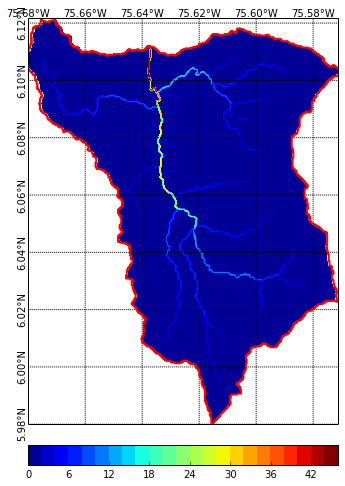

In [134]:
# Plot del caudal máximo para un periodo de retorno de 100
cuenca.Plot_basin(Qmax[5])

**Guardado en shp**:
Tanto la cuenca como la red hídrica se pueden guardar en **shp** para poder ser vistos en cualquier visor gis, tambien se puede guardar en otro tipo de archivos como **kml**.

In [137]:
cuenca.Save_Basin2Map('Cuenca.kml',DriverFormat='kml')

In [139]:
cuenca.Save_Net2Map('Red.kml',DriverFormat='kml',qmed=cuenca.CellQmed)

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:1327: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if qmed<>None:
/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:1348: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if qmed<>None:
/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:1370: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if qmed<>None:


## Geomorfologia

Aca se explica un poco las funciones que hay de geomorfología 

In [145]:
# Calcula geomorfología por cauces
cuenca.GetGeo_Cell_Basics()
# reporte de geomorfologia generico y los almacena en cuenca.GeoParameters y en cuenca.Tc
cuenca.GetGeo_Parameters()

In [146]:
cuenca.GeoParameters

{'Area[km2]': 96.321600000000004,
 'Centro [X]': -75.615509,
 'Centro [Y]': 6.0641594,
 'H Cauce Max [m]': 2322.0,
 'Hmax [m]': 2693.0,
 'Hmean [m]': 2160.4585,
 'Hmin [m]': 1719.0,
 'Long Cau [km]': 15.7085390625,
 'Long Cuenca [km]': 14.386555671691895,
 'Pend Cauce [%]': 3.820078301819084,
 'Pend Cuenca [%]': 36.9741290807724,
 'Perimetro[km]': 67.109999999999999}

In [147]:
# Tiempos de concentracion
cuenca.Tc

{'Campo y Munera': 1.6352061777814422,
 'Direccion Carreteras Espana': 1.0918016828389208,
 'Giandotti': 1.6894160564476481,
 'John Stone': 2.3497264377525942,
 'Kiprich': 1.8638359442022689,
 'Temez': 0.50371985277589559,
 'US Army': 1.2029352068671169,
 'Ventura': 0.41898809900420325}

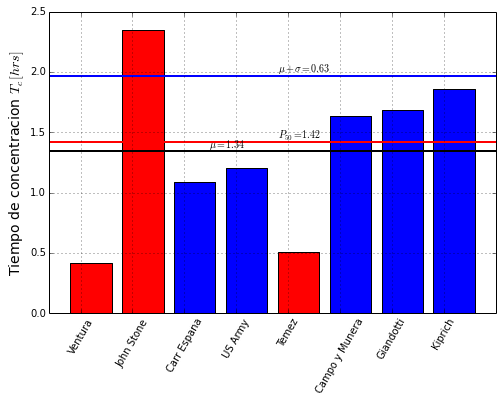

In [149]:
cuenca.Plot_Tc()

In [151]:
cuenca.GetGeo_IsoChrones(1.34)

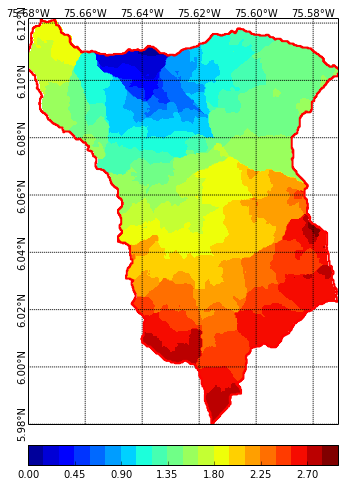

In [153]:
cuenca.Plot_basin(cuenca.CellTravelTime)

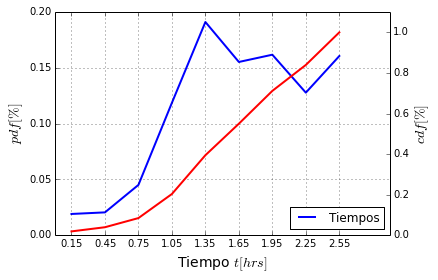

In [154]:
cuenca.Plot_Travell_Hist()

In [156]:
cuenca.GetGeo_Ppal_Hipsometric()

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:394: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  Y = pd.rolling_mean(Y,window)


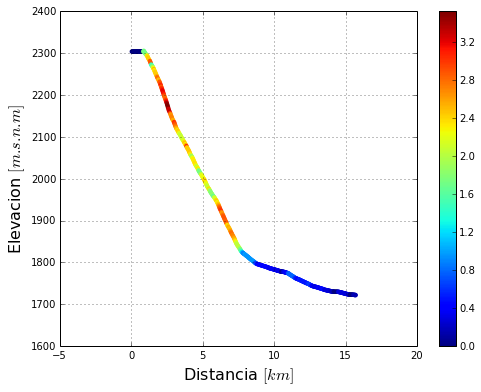

In [158]:
cuenca.PlotPpalStream()

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:1629: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  elevPpal=pd.rolling_mean(elevPpal,ventana)


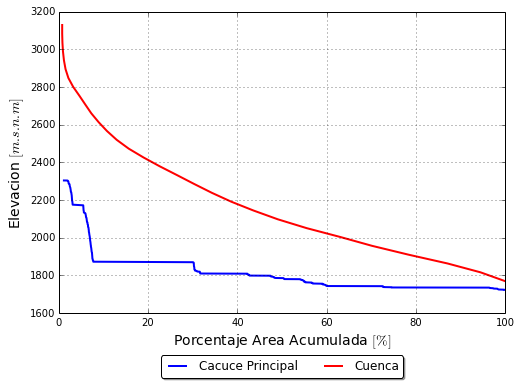

In [159]:
cuenca.Plot_Hipsometric()